In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']='-1'

from autoencoder import build_encoder, build_decoder
from data_utils import mu_law_expansion, LofiSequence

from IPython.display import Audio
import matplotlib.pyplot as plt
import mdct
import numpy as np
from scipy.io import wavfile
import seaborn as sns
sns.set_style('dark')

Using TensorFlow backend.


In [3]:
# dec_path = 'models/decoders/dec5_054_128709.069.h5'
# enc_path = 'models/encoders/enc5_054_128709.069.h5'
dec_path = 'selected_models/dec5_139_127441.444.h5'
enc_path = 'selected_models/enc5_139_127441.444.h5'
decoder = build_decoder()
encoder = build_encoder()[0]
encoder.load_weights(enc_path)
decoder.load_weights(dec_path)

In [4]:
lofi_seq = LofiSequence(batch_size=1)
len(lofi_seq)

878

In [45]:
true_song = lofi_seq[60][0]
gen_song = decoder.predict(encoder.predict(true_song)[2])

In [85]:
def spec_to_audio(spec):
    spec = spec.reshape(spec.shape[1:])
    return mdct.imdct(mu_law_expansion(spec, mu=511), framelength=256)

ts = spec_to_audio(true_song)
gs = spec_to_audio(gen_song)

In [86]:
ts.shape, np.min(ts), np.max(ts), gs.shape, np.min(gs), np.max(gs)

((130944, 2),
 -0.8885076391951707,
 0.9437767469140723,
 (130944, 2),
 -0.0033740270544693864,
 0.004781745043768433)

In [84]:
wavfile.write('true_song.wav', rate=8000, data=(32768 * ts).astype(np.int16))
wavfile.write('gen_song.wav', rate=8000, data=(40 * 32768 * gs).astype(np.int16))

In [31]:
xs = range(ts.shape[0])

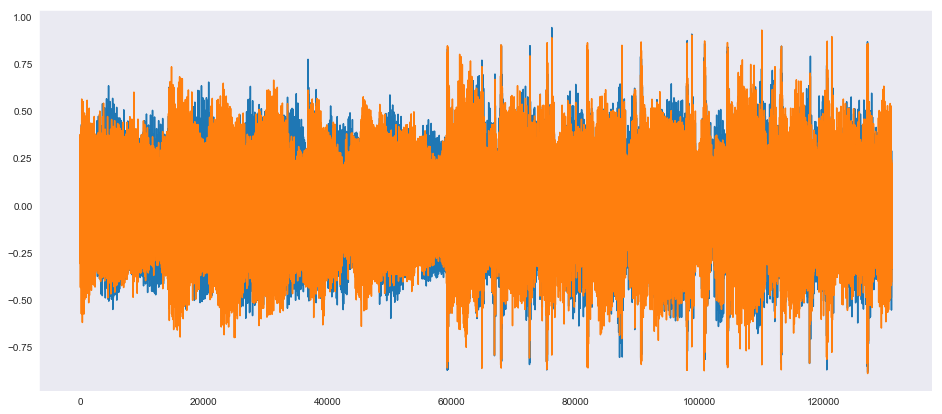

In [54]:
plt.figure(figsize=(16, 7))
plt.plot(xs, ts)

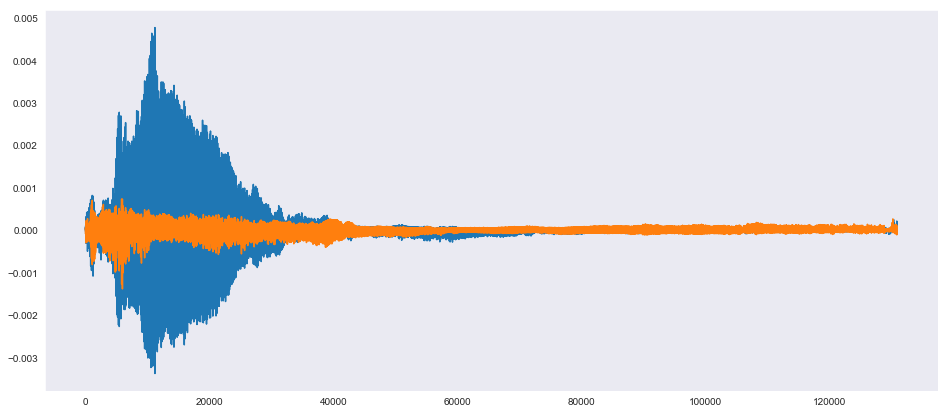

In [55]:
plt.figure(figsize=(16, 7))
plt.plot(xs, gs[:, ::-1])

In [36]:
eps = 1e-8

def specvis_stereo(arr):
    fig, axs = plt.subplots(2, 1, figsize=(18, 20))
    left = axs[0].imshow(arr[:, :, 0], label='Left channel', aspect='auto')
    right = axs[1].imshow(arr[:, :, 1], label='Right channel', aspect='auto')
    fig.colorbar(left, ax=axs[0])
    fig.colorbar(right, ax = axs[1])

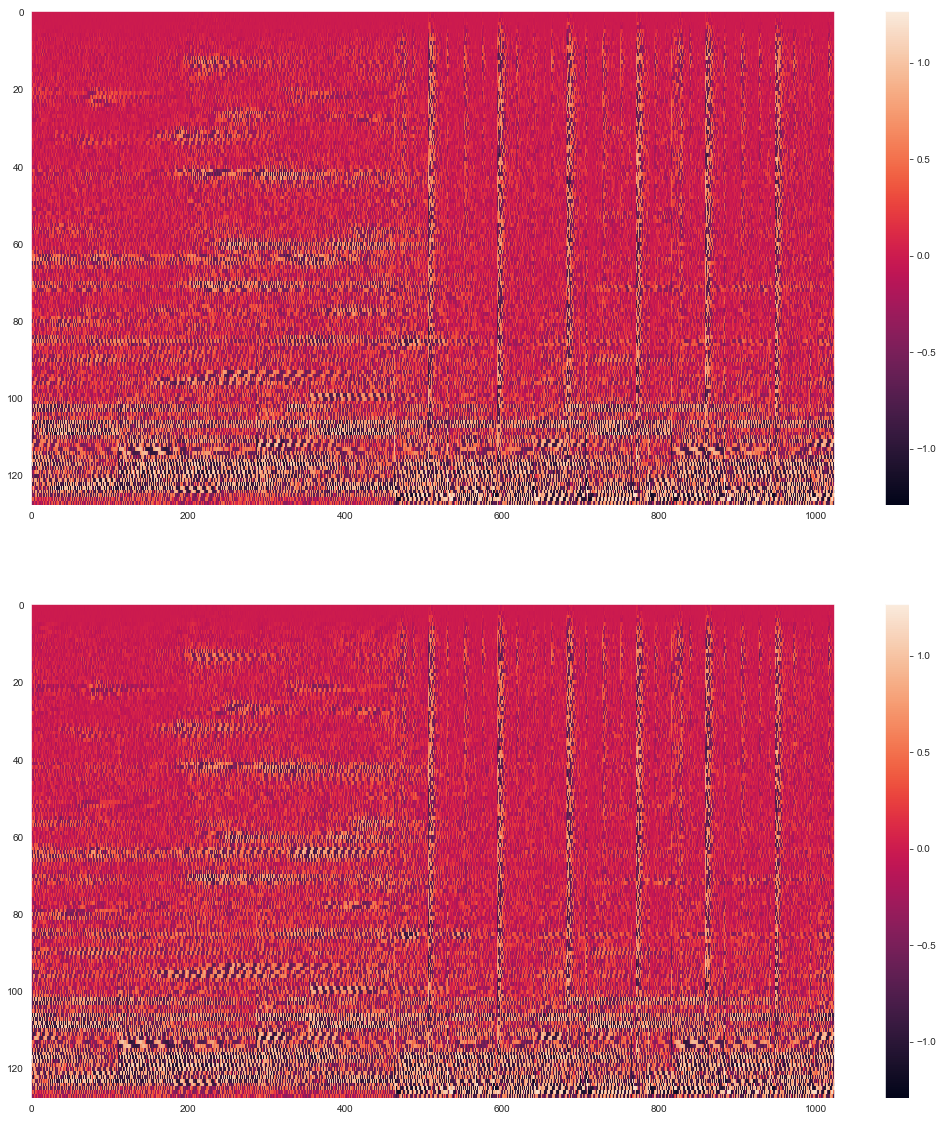

In [47]:
specvis_stereo(true_song.reshape(true_song.shape[1:])[::-1])

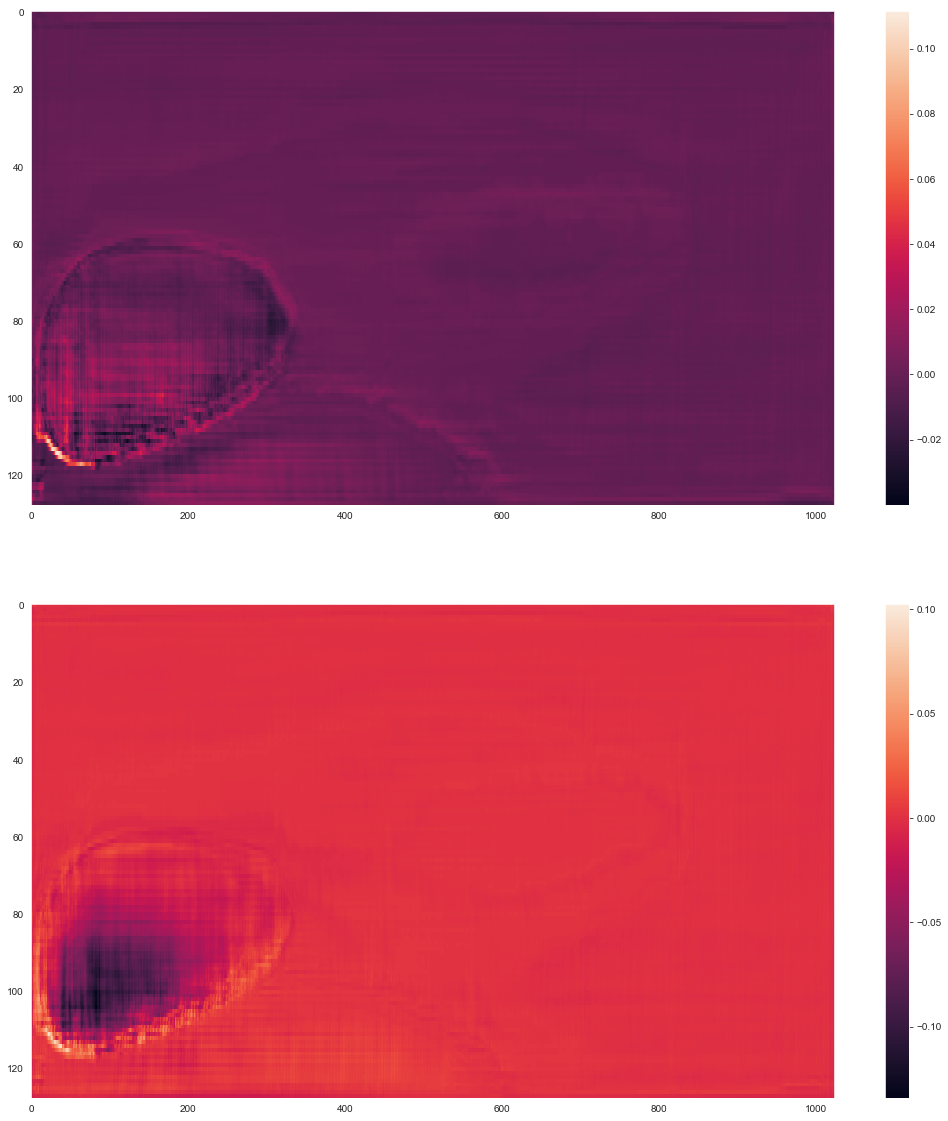

In [80]:
specvis_stereo(gen_song.reshape(gen_song.shape[1:])[::-1])

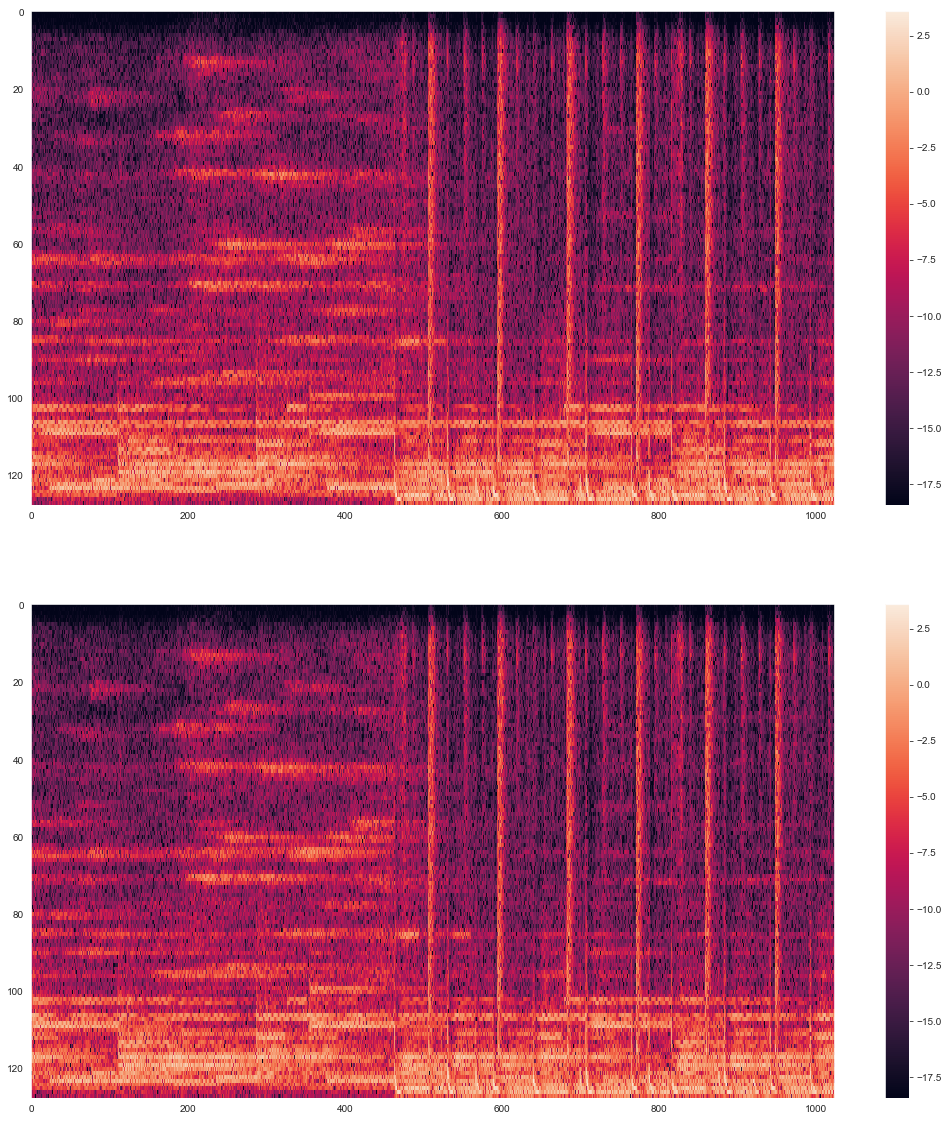

In [57]:
specvis_stereo(np.log(np.square(mu_law_expansion(true_song.reshape(true_song.shape[1:])[::-1], mu=511)) + eps))

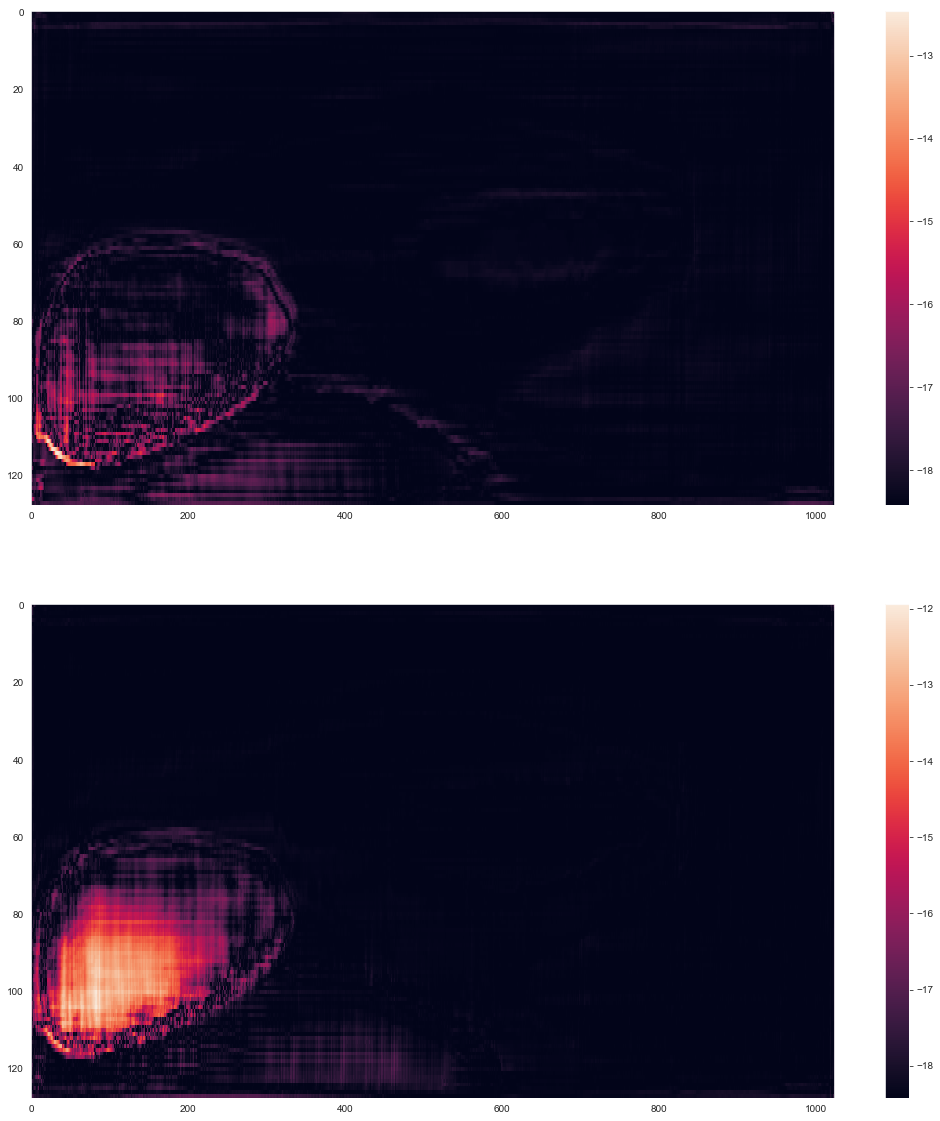

In [79]:
specvis_stereo(np.log(np.square(mu_law_expansion(gen_song.reshape(gen_song.shape[1:])[::-1], mu=511)) + eps))

**WHOA** I didn't see that coming!

Honestly, it is quite surprising that two mu-law "spectrograms" that look so similar can encode so different songs!

Well, let's see how sampling from the decoder works...

In [111]:
novel_song = decoder.predict(np.random.randn(1, 2, 2, 32))
novel_song.shape, np.min(novel_song), np.max(novel_song)

((1, 128, 1024, 2), -0.033547018, 0.022894394)

In [112]:
ns = spec_to_audio(novel_song)
wavfile.write('novel_song5.wav', rate=8000, data=(20 * 32767 * gs).astype(np.int16))

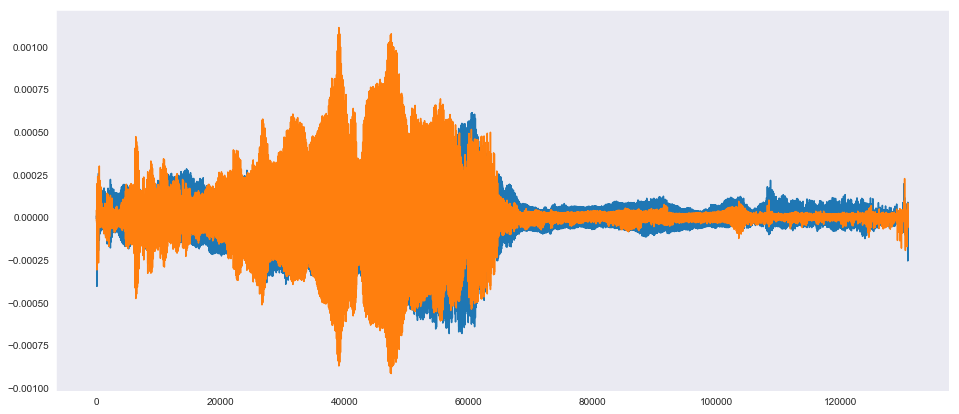

In [113]:
plt.figure(figsize=(16, 7))
plt.plot(xs, ns[:, ::1])

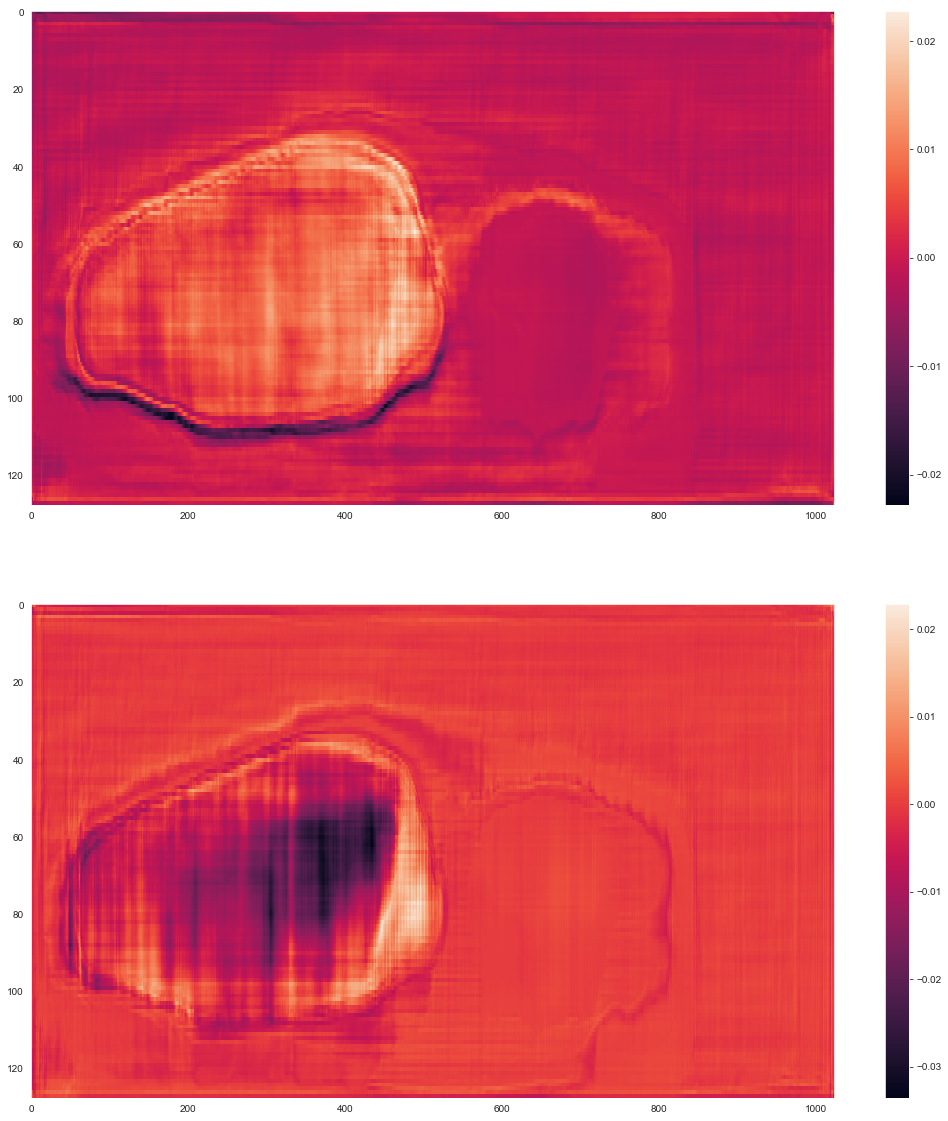

In [114]:
specvis_stereo(novel_song.reshape(novel_song.shape[1:])[::-1])

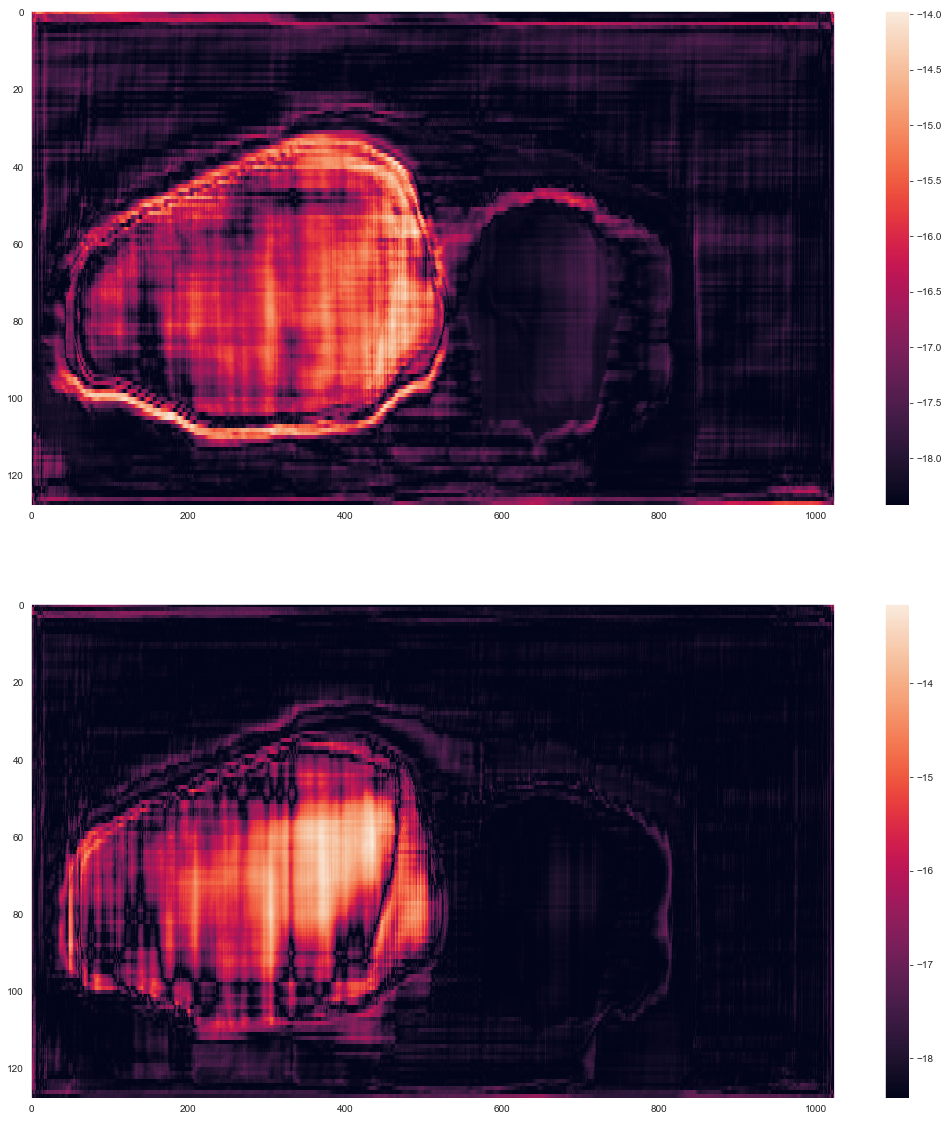

In [115]:
specvis_stereo(np.log(np.square(mu_law_expansion(novel_song.reshape(true_song.shape[1:])[::-1], mu=127)) + eps))